<a href="https://colab.research.google.com/github/Akhila636636/EventEase/blob/main/VJH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
# Install necessary libraries for geospatial analysis and interactive mapping
!pip install geopandas folium pandas numpy -q
print("Required libraries installed successfully!")

Required libraries installed successfully!


In [29]:
import pandas as pd
import numpy as np
import folium
import geopandas as gpd
from shapely.geometry import Point

# -----------------------------------------------------------
# SIMULATE THE DISEASE DATASET
# -----------------------------------------------------------
# We're simulating Dengue case counts for a few cities in a sample region of India (as per scope)
data = {
    'City': ['Hyderabad', 'Chennai', 'Bengaluru', 'Mumbai', 'Delhi', 'Kolkata'],
    'Latitude': [17.3850, 13.0827, 12.9716, 19.0760, 28.7041, 22.5726],
    'Longitude': [78.4867, 80.2707, 77.5946, 72.8777, 77.1025, 88.3639],
    'Confirmed_Cases_Last_2_Weeks': [550, 210, 80, 1200, 350, 950],
    'Population': [10000000, 7000000, 13000000, 20000000, 18000000, 15000000],
}
df = pd.DataFrame(data)

# Calculate a "Risk Index" to simulate the Hotspot identification using a simple ratio
# (Cases / Population) * 100000 to get cases per 100,000 people
df['Risk_Index'] = (df['Confirmed_Cases_Last_2_Weeks'] / df['Population']) * 100000
df = df.round(2)

print("Simulated Data (First 5 Rows):")
print(df.head())
print("\nDataFrame ready for Geospatial Analysis!")

Simulated Data (First 5 Rows):
        City  Latitude  Longitude  Confirmed_Cases_Last_2_Weeks  Population  \
0  Hyderabad     17.39      78.49                           550    10000000   
1    Chennai     13.08      80.27                           210     7000000   
2  Bengaluru     12.97      77.59                            80    13000000   
3     Mumbai     19.08      72.88                          1200    20000000   
4      Delhi     28.70      77.10                           350    18000000   

   Risk_Index  
0        5.50  
1        3.00  
2        0.62  
3        6.00  
4        1.94  

DataFrame ready for Geospatial Analysis!


In [30]:
# -----------------------------------------------------------
# GEOSPATIAL ANALYSIS AND MAP CREATION (Folium)
# -----------------------------------------------------------

# 1. Initialize a base map centered over India
india_center = [20.5937, 78.9629]
hotspot_map = folium.Map(location=india_center, zoom_start=4)

# Define a function to determine marker color based on the risk index
def get_color(risk):
    if risk >= 6.0:
        return 'darkred'  # High Risk (Hotspot)
    elif risk >= 3.0:
        return 'orange'   # Medium Risk
    else:
        return 'green'    # Low Risk

# 2. Iterate through the data and add markers to the map
for index, row in df.iterrows():
    # Create the popup text with key data
    popup_text = f"""
    <b>{row['City']}</b><br>
    Confirmed Cases: {row['Confirmed_Cases_Last_2_Weeks']}<br>
    <span style='color: {get_color(row['Risk_Index'])};'><b>Risk Index: {row['Risk_Index']}</b></span>
    """

    # Add a CircleMarker for better visualization of hotspots
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=10,
        color=get_color(row['Risk_Index']),
        fill=True,
        fill_color=get_color(row['Risk_Index']),
        fill_opacity=0.7,
        popup=folium.Popup(popup_text, max_width=300)
    ).add_to(hotspot_map)

# Display the map in Colab
print("Interactive Hotspot Map Generated (Scroll down to view):")
hotspot_map

Interactive Hotspot Map Generated (Scroll down to view):


In [31]:
# Install the XGBoost library (eXtreme Gradient Boosting)
!pip install xgboost -q
print("XGBoost installed successfully!")

XGBoost installed successfully!


In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# -----------------------------------------------------------
# SIMULATE 100 DAYS OF DAILY CASES FOR ONE CITY (e.g., Delhi)
# -----------------------------------------------------------
np.random.seed(42)
days = pd.date_range(start='2024-07-01', periods=100, freq='D')

# Create a baseline for cases (simulating a summer/monsoon increase)
base_cases = np.sin(np.linspace(0, 2*np.pi, 100)) * 50 + 100
# Add random noise
daily_cases = (base_cases + np.random.normal(0, 15, 100)).astype(int)
daily_cases[daily_cases < 0] = 0 # Ensure cases are non-negative

# Simulate features: Rainfall and Temperature
rainfall = np.random.normal(loc=15, scale=5, size=100).clip(min=0).round(1)
temp = np.random.normal(loc=30, scale=3, size=100).round(1)

# Create the DataFrame
ts_df = pd.DataFrame({
    'Date': days,
    'Daily_Cases': daily_cases,
    'Rainfall_mm': rainfall,
    'Avg_Temp_C': temp
})
ts_df.set_index('Date', inplace=True)

print("Simulated Time-Series Data (Cases, Rainfall, Temp):")
print(ts_df.tail())

Simulated Time-Series Data (Cases, Rainfall, Temp):
            Daily_Cases  Rainfall_mm  Avg_Temp_C
Date                                            
2024-10-04           65         16.9        27.9
2024-10-05           94         10.6        32.7
2024-10-06           97         15.8        30.9
2024-10-07           96         15.3        32.4
2024-10-08           96          9.3        31.9


In [33]:
# -----------------------------------------------------------
# FEATURE ENGINEERING: CREATING LAGS
# -----------------------------------------------------------

def create_time_series_features(df, lags=[1, 7, 14]):
    """Creates lagged features for cases, rainfall, and temperature."""
    for lag in lags:
        # Lagged Daily_Cases (Past Cases)
        df[f'Cases_Lag_{lag}'] = df['Daily_Cases'].shift(lag)
        # Lagged Environmental Factors (to represent a delayed effect)
        df[f'Rainfall_Lag_{lag}'] = df['Rainfall_mm'].shift(lag)
        df[f'Temp_Lag_{lag}'] = df['Avg_Temp_C'].shift(lag)

    # Drop rows with NaN values created by lagging (the first 14 days)
    return df.dropna()

# Apply the feature creation
model_df = create_time_series_features(ts_df.copy())

# Define the target and features
TARGET = 'Daily_Cases'
FEATURES = [col for col in model_df.columns if col != TARGET]

print("\nData ready for XGBoost (Features include past data):")
print(model_df.head())


Data ready for XGBoost (Features include past data):
            Daily_Cases  Rainfall_mm  Avg_Temp_C  Cases_Lag_1  Rainfall_Lag_1  \
Date                                                                            
2024-07-15          112         14.0        29.1        108.0            27.3   
2024-07-16          132         16.5        32.3        112.0            14.0   
2024-07-17          127         14.8        27.7        132.0            16.5   
2024-07-18          148          9.2        29.3        127.0            14.8   
2024-07-19          131         20.7        28.5        148.0             9.2   

            Temp_Lag_1  Cases_Lag_7  Rainfall_Lag_7  Temp_Lag_7  Cases_Lag_14  \
Date                                                                            
2024-07-15        32.0        133.0            15.9        31.5         107.0   
2024-07-16        29.1        117.0            16.3        31.5         101.0   
2024-07-17        32.3        135.0            14.6   

In [34]:
# -----------------------------------------------------------
# TRAINING THE XGBOOST MODEL
# -----------------------------------------------------------

# Split the data chronologically: 80% for training, 20% for testing
split_point = int(len(model_df) * 0.8)
train = model_df.iloc[:split_point]
test = model_df.iloc[split_point:]

X_train, y_train = train[FEATURES], train[TARGET]
X_test, y_test = test[FEATURES], test[TARGET]

# Initialize and Train the XGBoost Regressor
# We use 'reg:squarederror' for a regression (prediction of a continuous number) task
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.05,
    random_state=42
)

# Fit the model to the training data
xgb_model.fit(X_train, y_train)

# Predict on the test set to evaluate
test_predictions = xgb_model.predict(X_test)
test_predictions = test_predictions.round().clip(min=0) # Round and ensure non-negative

# Simple evaluation (Mean Absolute Error)
mae = np.mean(np.abs(test_predictions - y_test))
print(f"\nModel Trained. Mean Absolute Error on Test Data: {mae:.2f} cases/day")


Model Trained. Mean Absolute Error on Test Data: 24.17 cases/day


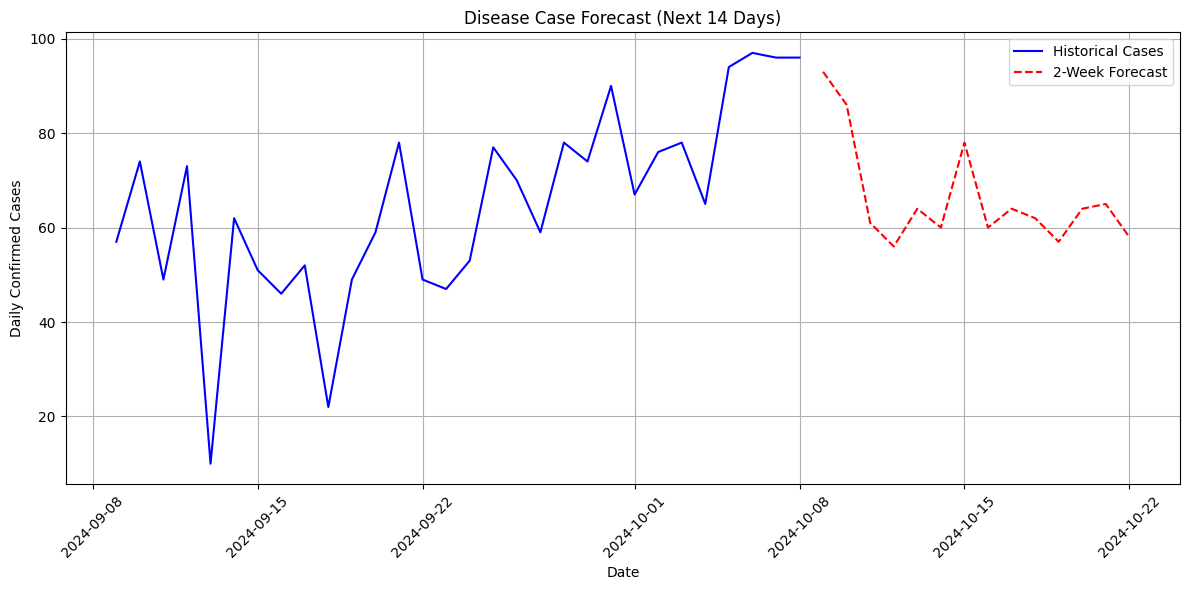


Forecasting complete!


In [35]:
# -----------------------------------------------------------
# GENERATING THE 2-WEEK FORECAST (Final Robust Code)
# -----------------------------------------------------------
# Note: You MUST run the previous cells (2.2, 2.3, 2.4) to define ts_df,
# create_time_series_features, and xgb_model before running this cell.

# 1. Define the features the model was trained on
FEATURES = [
    'Rainfall_mm', 'Avg_Temp_C',
    'Cases_Lag_1', 'Rainfall_Lag_1', 'Temp_Lag_1',
    'Cases_Lag_7', 'Rainfall_Lag_7', 'Temp_Lag_7',
    'Cases_Lag_14', 'Rainfall_Lag_14', 'Temp_Lag_14'
]

# 2. Re-train the model on ALL data (best practice for final forecasting)
model_df = create_time_series_features(ts_df.copy())
X, y = model_df[FEATURES], model_df['Daily_Cases']
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.05, random_state=42)
xgb_model.fit(X, y)

# --- SETUP FOR ROLLING FORECAST ---
forecast_period = 14
predicted_cases = []

# Get the last 14 ACTUAL data points from the time-series. This is our rolling data window.
current_data = ts_df.tail(14).copy()

# Create dates for the next 14 forecast days
forecast_dates = pd.date_range(start=ts_df.index[-1] + pd.Timedelta(days=1), periods=forecast_period, freq='D')

# 3. The Rolling Forecast Loop: Predict day-by-day
for i in range(forecast_period):

    # Manually build the input feature vector (X_today) for the model
    # We explicitly pull the required lag values from the current_data window (always 14 rows)
    X_today = pd.DataFrame({
        # Today's Environmental Features (using mean as the future placeholder)
        'Rainfall_mm': [np.mean(ts_df['Rainfall_mm'])],
        'Avg_Temp_C': [np.mean(ts_df['Avg_Temp_C'])],

        # Lag 1: Yesterday's data (the last row in the 14-day window)
        'Cases_Lag_1': [current_data['Daily_Cases'].iloc[-1]],
        'Rainfall_Lag_1': [current_data['Rainfall_mm'].iloc[-1]],
        'Temp_Lag_1': [current_data['Avg_Temp_C'].iloc[-1]],

        # Lag 7: Data from 7 days ago (the 8th row in the 14-day window)
        'Cases_Lag_7': [current_data['Daily_Cases'].iloc[-7]],
        'Rainfall_Lag_7': [current_data['Rainfall_mm'].iloc[-7]],
        'Temp_Lag_7': [current_data['Avg_Temp_C'].iloc[-7]],

        # Lag 14: Data from 14 days ago (the 1st row in the 14-day window)
        'Cases_Lag_14': [current_data['Daily_Cases'].iloc[0]],
        'Rainfall_Lag_14': [current_data['Rainfall_mm'].iloc[0]],
        'Temp_Lag_14': [current_data['Avg_Temp_C'].iloc[0]],
    })

    # Predict the cases for today
    prediction = xgb_model.predict(X_today)[0]
    prediction = int(max(0, round(prediction)))
    predicted_cases.append(prediction)

    # Update the current_data buffer (Rolling Window): Drop the oldest row and add the new prediction
    new_row_date = forecast_dates[i]
    new_row = pd.Series(
        {
            'Daily_Cases': prediction,
            'Rainfall_mm': np.mean(ts_df['Rainfall_mm']), # Re-add placeholders
            'Avg_Temp_C': np.mean(ts_df['Avg_Temp_C']),
        }, name=new_row_date)

    # Drop the oldest row (iloc[1:]) and append the new predicted row
    current_data = pd.concat([current_data.iloc[1:], new_row.to_frame().T], axis=0)


# 4. Create the final forecast output (Will now have 14 predicted values)
forecast_output = pd.DataFrame({'Predicted_Cases': predicted_cases}, index=forecast_dates)

# Combine historical data and forecast for the chart
plot_data = pd.concat([ts_df.tail(30), forecast_output], axis=0)

# Generate the plot
plt.figure(figsize=(12, 6))
plt.plot(plot_data.index[:-14], plot_data['Daily_Cases'].iloc[:-14], label='Historical Cases', color='blue')
plt.plot(plot_data.index[-14:], plot_data['Predicted_Cases'].iloc[-14:], label='2-Week Forecast', color='red', linestyle='--')
plt.title('Disease Case Forecast (Next 14 Days)')
plt.xlabel('Date')
plt.ylabel('Daily Confirmed Cases')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nForecasting complete!")

**Step 3**

In [36]:
# Install Streamlit and required dependencies
!pip install streamlit streamlit_folium -q
print("Streamlit installed for web app development!")

Streamlit installed for web app development!


In [42]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
import folium
from streamlit_folium import folium_static
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# --- 1. CONFIGURATION AND UTILITY FUNCTIONS ---

# Set up the Streamlit page
st.set_page_config(layout="wide", page_title="India Disease Forecasting & Hotspot Dashboard")

def create_time_series_features(df, lags=[1, 7, 14]):
    """Creates lagged features for cases, rainfall, and temperature."""
    for lag in lags:
        df[f'Cases_Lag_{lag}'] = df['Daily_Cases'].shift(lag)
        df[f'Rainfall_Lag_{lag}'] = df['Rainfall_mm'].shift(lag)
        df[f'Temp_Lag_{lag}'] = df['Avg_Temp_C'].shift(lag)
    # NOTE: We keep this function for initial model training, but we DONT use it in the rolling forecast loop.
    return df.dropna()

def get_color(risk):
    """Determines marker color based on the risk index."""
    if risk >= 6.0:
        return 'darkred'  # High Risk (Hotspot)
    elif risk >= 3.0:
        return 'orange'   # Medium Risk
    else:
        return 'green'    # Low Risk

# --- 2. DATA SIMULATION ---

@st.cache_data
def load_and_process_data():
    # Hotspot Data Simulation
    hotspot_data = {
        'City': ['Hyderabad', 'Chennai', 'Bengaluru', 'Mumbai', 'Delhi', 'Kolkata'],
        'Latitude': [17.3850, 13.0827, 12.9716, 19.0760, 28.7041, 22.5726],
        'Longitude': [78.4867, 80.2707, 77.5946, 72.8777, 77.1025, 88.3639],
        'Confirmed_Cases_Last_2_Weeks': [550, 210, 80, 1200, 350, 950],
        'Population': [10000000, 7000000, 13000000, 20000000, 18000000, 15000000],
    }
    df_hotspot = pd.DataFrame(hotspot_data)
    df_hotspot['Risk_Index'] = (df_hotspot['Confirmed_Cases_Last_2_Weeks'] / df_hotspot['Population']) * 100000
    df_hotspot = df_hotspot.round(2)

    # Time-Series Data Simulation
    np.random.seed(42)
    days = pd.date_range(start='2024-07-01', periods=100, freq='D')
    base_cases = np.sin(np.linspace(0, 2*np.pi, 100)) * 50 + 100
    daily_cases = (base_cases + np.random.normal(0, 15, 100)).astype(int)
    daily_cases[daily_cases < 0] = 0
    rainfall = np.random.normal(loc=15, scale=5, size=100).clip(min=0).round(1)
    temp = np.random.normal(loc=30, scale=3, size=100).round(1)
    ts_df = pd.DataFrame({
        'Date': days,
        'Daily_Cases': daily_cases,
        'Rainfall_mm': rainfall,
        'Avg_Temp_C': temp
    }).set_index('Date')

    return df_hotspot, ts_df

df_hotspot, ts_df = load_and_process_data()

# --- 3. HOTSPOT MAP MODULE (UNCHANGED) ---

def create_hotspot_map(df):
    st.subheader("Interactive Disease Hotspot Map 🗺️")
    st.markdown("Identifies high-risk areas using a dynamically calculated **Risk Index** (Cases per 100,000 population).")

    india_center = [20.5937, 78.9629]
    hotspot_map = folium.Map(location=india_center, zoom_start=4)

    for index, row in df.iterrows():
        popup_text = f"""
        <b>{row['City']}</b><br>
        Confirmed Cases: {row['Confirmed_Cases_Last_2_Weeks']}<br>
        <span style='color: {get_color(row['Risk_Index'])};'><b>Risk Index: {row['Risk_Index']}</b></span>
        """
        folium.CircleMarker(
            location=[row['Latitude'], row['Longitude']],
            radius=10,
            color=get_color(row['Risk_Index']),
            fill=True,
            fill_color=get_color(row['Risk_Index']),
            fill_opacity=0.7,
            popup=folium.Popup(popup_text, max_width=300)
        ).add_to(hotspot_map)

    # Display the map in Streamlit
    folium_static(hotspot_map, width=1200, height=450)

    # Legend
    col1, col2, col3 = st.columns(3)
    col1.markdown("🔴 **High Risk** (Risk Index $\ge 6.0$)")
    col2.markdown("🟠 **Medium Risk** ($3.0 \le$ Risk Index $< 6.0$)")
    col3.markdown("🟢 **Low Risk** (Risk Index $< 3.0$)")

# --- 4. FORECASTING MODULE (FIXED) ---

def create_forecast_chart(ts_df):
    st.subheader("Disease Case Forecasting (2-Week Projection) 📈")
    st.markdown("Utilizes the **XGBoost Machine Learning Model** trained on historical cases and environmental factors.")

    # 1. Define the features the model was trained on
    FEATURES = [
        'Rainfall_mm', 'Avg_Temp_C',
        'Cases_Lag_1', 'Rainfall_Lag_1', 'Temp_Lag_1',
        'Cases_Lag_7', 'Rainfall_Lag_7', 'Temp_Lag_7',
        'Cases_Lag_14', 'Rainfall_Lag_14', 'Temp_Lag_14'
    ]

    # 2. Train the model (using the initial feature creation that drops NaNs)
    model_df = create_time_series_features(ts_df.copy())
    X, y = model_df[FEATURES], model_df['Daily_Cases']
    xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.05, random_state=42)
    xgb_model.fit(X, y)

    # --- SETUP FOR ROLLING FORECAST ---
    forecast_period = 14
    predicted_cases = []

    # Get the last 14 ACTUAL data points. This is our rolling data window.
    current_data = ts_df.tail(14).copy()

    # Create dates for the next 14 forecast days
    forecast_dates = pd.date_range(start=ts_df.index[-1] + pd.Timedelta(days=1), periods=forecast_period, freq='D')

    # 3. The Rolling Forecast Loop: Predict day-by-day (MANUAL FEATURE BUILDING)
    for i in range(forecast_period):

        # Manually build the input feature vector (X_today) for the model
        X_today = pd.DataFrame({
            # Today's Environmental Features (using mean as the future placeholder)
            'Rainfall_mm': [np.mean(ts_df['Rainfall_mm'])],
            'Avg_Temp_C': [np.mean(ts_df['Avg_Temp_C'])],

            # Lag 1: Yesterday's data (the last row in the 14-day window)
            'Cases_Lag_1': [current_data['Daily_Cases'].iloc[-1]],
            'Rainfall_Lag_1': [current_data['Rainfall_mm'].iloc[-1]],
            'Temp_Lag_1': [current_data['Avg_Temp_C'].iloc[-1]],

            # Lag 7: Data from 7 days ago (the 8th row in the 14-day window)
            'Cases_Lag_7': [current_data['Daily_Cases'].iloc[-7]],
            'Rainfall_Lag_7': [current_data['Rainfall_mm'].iloc[-7]],
            'Temp_Lag_7': [current_data['Avg_Temp_C'].iloc[-7]],

            # Lag 14: Data from 14 days ago (the 1st row in the 14-day window)
            'Cases_Lag_14': [current_data['Daily_Cases'].iloc[0]],
            'Rainfall_Lag_14': [current_data['Rainfall_mm'].iloc[0]],
            'Temp_Lag_14': [current_data['Avg_Temp_C'].iloc[0]],
        })

        # Predict the cases for today
        prediction = xgb_model.predict(X_today)[0]
        prediction = int(max(0, round(prediction)))
        predicted_cases.append(prediction)

        # Update the current_data buffer (Rolling Window): Drop the oldest row and add the new prediction
        new_row_date = forecast_dates[i]
        new_row = pd.Series(
            {
                'Daily_Cases': prediction,
                'Rainfall_mm': np.mean(ts_df['Rainfall_mm']),
                'Avg_Temp_C': np.mean(ts_df['Avg_Temp_C']),
            }, name=new_row_date)

        # Drop the oldest row (iloc[1:]) and append the new predicted row
        current_data = pd.concat([current_data.iloc[1:], new_row.to_frame().T], axis=0)


    # 4. Create the final forecast output
    forecast_output = pd.DataFrame({'Predicted_Cases': predicted_cases}, index=forecast_dates)
    plot_data = pd.concat([ts_df.tail(30), forecast_output], axis=0)

    # Generate the plot
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(plot_data.index[:-14], plot_data['Daily_Cases'].iloc[:-14], label='Historical Cases', color='blue')
    ax.plot(plot_data.index[-14:], plot_data['Predicted_Cases'].iloc[-14:], label='2-Week Forecast', color='red', linestyle='--')
    ax.axvline(x=plot_data.index[-15], color='grey', linestyle=':', label='Forecast Start')
    ax.set_title(f'2-Week Disease Case Forecast (City: Delhi Sample)', fontsize=14)
    ax.set_xlabel('Date')
    ax.set_ylabel('Daily Confirmed Cases')
    ax.legend()
    ax.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()

    st.pyplot(fig)

# --- 5. DASHBOARD LAYOUT (MAIN FUNCTION) ---

def main():
    st.title("Project: Data-Driven Disease Forecasting & Hotspot Identification")
    st.markdown("""
    **HACKATHON PROTOTYPE:** A **Full-Stack** system for public health intervention, combining Geospatial Analysis (Hotspots) with Machine Learning (Forecasting).
    """)

    st.markdown("---")
    create_hotspot_map(df_hotspot)

    st.markdown("---")
    create_forecast_chart(ts_df)

    st.markdown("---")
    st.subheader("Future Scope (Multi-Lingual and Real-Time)")
    st.info("""
    The system is designed for multi-lingual scalability and real-time data integration. This prototype demonstrates the core technology stack: **Python, Pandas, GeoPandas/Folium, XGBoost, and Streamlit**.
    """)

if __name__ == "__main__":
    main()

Overwriting app.py


**Deploying with ngrok**

In [44]:
# Kill all processes on port 8501
!fuser -k 8501/tcp 2>/dev/null
# Kill any background ngrok processes
!pkill ngrok 2>/dev/null
print("Environment cleaned. Ready for final deployment.")

 31546Environment cleaned. Ready for final deployment.


In [45]:
import os
import subprocess
from pyngrok import ngrok

# 1. PASTE YOUR AUTH TOKEN HERE!
AUTH_TOKEN = "34BJRmT2812KdJIx8HPlU7CYkCk_4F3p9MMDFFMXHspYRwHM"

# Authenticate ngrok
ngrok.set_auth_token(AUTH_TOKEN)
ngrok.kill() # Stop any previous tunnels

# Start Streamlit in the background
streamlit_process = subprocess.Popen([
    'streamlit', 'run', 'app.py',
    '--server.port', '8501',
    '--server.enableCORS', 'False',
    '--server.enableXsrfProtection', 'False'
])

print("Streamlit app is starting on port 8501...")
import time
time.sleep(5)

# Open a public ngrok tunnel
public_url = ngrok.connect(8501)

print("\n---------------------------------------------------")
print(f"🎉 Your Live Dashboard URL (Click Here): {public_url}")
print("---------------------------------------------------")

Streamlit app is starting on port 8501...

---------------------------------------------------
🎉 Your Live Dashboard URL (Click Here): NgrokTunnel: "https://toilfully-nonpecuniary-kacy.ngrok-free.dev" -> "http://localhost:8501"
---------------------------------------------------
